In [1]:
print("strawberry")

strawberry


In [1]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

### Set the seed

In [3]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [4]:
is3D = False

In [5]:
#root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [6]:
domains = [
            wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
          ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


# domains = [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]

In [7]:
import kornia

In [8]:
from typing import Dict, Tuple
def create_random_labels_map(classes: int):
    labels_map: Dict[int, Tuple[int, int, int]] = {}
    for i in classes:
        labels_map[i] = torch.randint(0, 255, (3, ))
    labels_map[0] = torch.zeros(3)
    return labels_map


def labels_to_image(img_labels: torch.Tensor, labels_map: Dict[int, Tuple[int, int, int]]) -> torch.Tensor:
    """Function that given an image with labels ids and their pixels intrensity mapping, creates a RGB
    representation for visualisation purposes."""
    assert len(img_labels.shape) == 2, img_labels.shape
    H, W = img_labels.shape
    out = torch.empty(3, H, W, dtype=torch.uint8)
    for label_id, label_val in labels_map.items():
        mask = (img_labels == label_id)
        for i in range(3):
            out[i].masked_fill_(mask, label_val[i])
    return out

In [9]:
def compute_points(label):
    out = kornia.contrib.connected_components(label.unsqueeze(0).type(torch.float32), num_iterations=200)
    labels_map = create_random_labels_map(torch.unique(out))
    uniques = torch.unique(out)[1:] # remove the background label
    
    points = torch.ones(50,2) * -1
    for i, u in enumerate(uniques):
        wheres = torch.where(out ==u)
        xi = torch.median(wheres[1])
        yi = torch.median(wheres[2])
        points[i] = torch.Tensor([xi, yi])
        
    return torch.Tensor(points)

In [10]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        #transforms.append(lambda x, y : (x, compute_points(y)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [11]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [12]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [13]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2506, 716, 358)

In [14]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

### setup model

In [15]:
in_channels = 3
out_channels = 1

if is3D:
    pass
else:
    # encoder_features=[16, 32, 64, 128, 256] # orig: [16, 32, 64, 128, 256]
    # decoder_features=encoder_features[::-1][1:]
    model = HyperMapp3r(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }
                   )
    
    
    optimizer_params={"lr":2e-3}
    lr_scheduler_params={"step_size":20, "gamma":0.1}
    # optimizer_params={"lr":2e-3, "momentum":0.6}
    # optimizer = torch.optim.RMSprop
    # lr_scheduler_params={"milestones":[10,100,200], "gamma":0.5}
    # lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR


In [16]:
summary(model, (1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
HyperMapp3r                              --                        --
├─ModuleList: 1-1                        --                        --
├─ModuleList: 1-2                        --                        --
├─ModuleList: 1-3                        --                        --
├─ModuleList: 1-4                        --                        --
├─ModuleList: 1-5                        --                        --
├─ModuleList: 1-2                        --                        --
│    └─Conv2d: 2-1                       [1, 16, 64, 64]           448
├─ModuleList: 1-1                        --                        --
│    └─HM3Block: 2-2                     [1, 16, 64, 64]           --
│    │    └─InstanceNorm2d: 3-1          [1, 16, 64, 64]           --
│    │    └─LeakyReLU: 3-2               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-3                  [1, 16, 64, 64]           2,304
│    │    └

In [17]:
#loss = dice_loss
#loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.968, 0.032]))
#loss = FocalLoss(gamma=1., reduction='mean', alpha=torch.Tensor([1-0.968, 1-0.032]))
#loss = log_cosh_dice_loss
#loss = TverskyLoss(beta=0.7)
#loss = FocalTverskyLoss(beta=0.7, gamma=0.8)

### trying the connected components style loss

In [18]:
x, y = next(iter(train_dataloader))

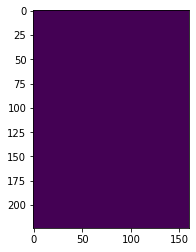

In [19]:
plt.imshow(y[0])

In [20]:
compute_points(y[0])

tensor([[-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.]])

TypeError: Invalid shape (3, 224, 160) for image data

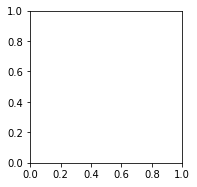

In [21]:
plt.subplot(1,2,1)
plt.imshow(x[0]); plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(y.squeeze()); plt.axis("off")
plt.show()

In [27]:
y = y[0]

In [29]:
#compute_points(y)

In [30]:
out = kornia.contrib.connected_components(y.unsqueeze(0).type(torch.float32), num_iterations=200)

In [31]:
labels_map = create_random_labels_map(torch.unique(out))

In [32]:
img = labels_to_image(out.squeeze(), labels_map)

(-0.5, 159.5, 223.5, -0.5)

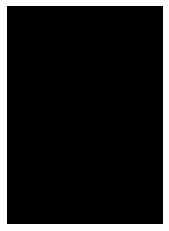

In [33]:
plt.imshow(img.permute(1,2,0)); plt.axis("off")

In [34]:
uniques = torch.unique(out)[1:]

In [35]:
uniques

tensor([])

In [36]:
cc = 4
wheres = torch.where(out ==uniques[cc])
xi = torch.median(wheres[1])
yi = torch.median(wheres[2])

z = torch.zeros(out.shape)
#z[0,xi,yi] = 255

IndexError: index 4 is out of bounds for dimension 0 with size 0

In [37]:
xi, yi

NameError: name 'xi' is not defined

IndexError: index 4 is out of bounds for dimension 0 with size 0

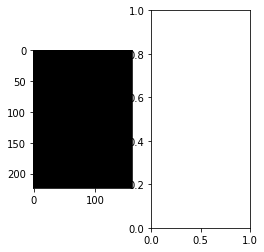

In [38]:
plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(out.squeeze() == uniques[cc])
plt.subplot(1,3,3)
plt.scatter(yi, out.shape[1]-xi)
plt.xlim((0,z.shape[2]))
plt.ylim((0, z.shape[1]))
plt.yticks([])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [575]:
def medians(conn_comps):
    uniques = torch.unique(conn_comps)[1:] # remove the background connected component.
    locs = torch.zeros(uniques.shape[0], 2)
    for i, u in enumerate(uniques):
        wheres = torch.where(conn_comps == u)
        xi = torch.median(wheres[1])
        yi = torch.median(wheres[2])
        locs[i,0] = xi
        locs[i,1] = yi
    return locs

In [576]:
medians(out)

tensor([[ 78., 119.],
        [ 84.,  37.],
        [ 86., 119.],
        [ 96., 107.],
        [ 97.,  54.]])

In [66]:
"""
I want to minimise the distance between all the global maxima, and the different regions .
I can do this by a greedy matching from voxel location maxima to the output of the image, this is real nice.
"""

'\nI want to minimise the distance between all the global maxima, and the different regions .\nI can do this by a greedy matching from voxel location maxima to the output of the image, this is real nice.\n'

In [46]:
import torch.nn as nn# class to compute image gradients in pytorch
import numpy as np

class RGBgradients(nn.Module):
    def __init__(self, weight): # weight is a numpy array
        super().__init__()
        k_height, k_width = weight.shape[1:]
        # assuming that the height and width of the kernel are always odd numbers
        padding_x = int((k_height-1)/2)
        padding_y = int((k_width-1)/2)
        
        # convolutional layer with 3 in_channels and 6 out_channels 
        # the 3 in_channels are the color channels of the image
        # for each in_channel we have 2 out_channels corresponding to the x and the y gradients
        self.conv = nn.Conv2d(1, 2, (k_height, k_width), bias = False, 
                              padding = (padding_x, padding_y) )
        # initialize the weights of the convolutional layer to be the one provided
        # the weights correspond to the x/y filter for the channel in question and zeros for other channels
        
        weight1x = np.array([weight[0]]) # x-derivative for 1st in_channel
        
        weight1y = np.array([weight[1]]) # y-derivative for 1st in_channel
#         weight1x = np.array([weight[0], 
#                              np.zeros((k_height, k_width)), 
#                              np.zeros((k_height, k_width))]) # x-derivative for 1st in_channel
        
#         weight1y = np.array([weight[1], 
#                              np.zeros((k_height, k_width)), 
#                              np.zeros((k_height, k_width))]) # y-derivative for 1st in_channel
        
#         weight2x = np.array([np.zeros((k_height, k_width)),
#                              weight[0],
#                              np.zeros((k_height, k_width))]) # x-derivative for 2nd in_channel
        
#         weight2y = np.array([np.zeros((k_height, k_width)), 
#                              weight[1],
#                              np.zeros((k_height, k_width))]) # y-derivative for 2nd in_channel
        
        
#         weight3x = np.array([np.zeros((k_height, k_width)),
#                              np.zeros((k_height, k_width)),
#                              weight[0]]) # x-derivative for 3rd in_channel
        
#         weight3y = np.array([np.zeros((k_height, k_width)),
#                              np.zeros((k_height, k_width)), 
#                              weight[1]]) # y-derivative for 3rd in_channel
        
        weight_final = torch.from_numpy(np.array([
            weight1x, weight1y, 
            #weight2x, weight2y,
            #weight3x, weight3y
        ])).type(torch.FloatTensor)
        
        if self.conv.weight.shape == weight_final.shape:
            self.conv.weight = nn.Parameter(weight_final)
            self.conv.weight.requires_grad_(False)
        else:
            print('Error: The shape of the given weights is not correct')
    
    # Note that a second way to define the conv. layer here would be to pass group = 3 when calling torch.nn.Conv2d
    
    def forward(self, x):
        return self.conv(x)
    
    
filter_x = np.array([[-3, 0, 3], 
                     [-10, 0, 10],
                     [-3, 0, 3]])

filter_y = filter_x.T
grad_filters = np.array([filter_x, filter_y])

gradLayer = RGBgradients(grad_filters)

In [47]:
gradLayer

RGBgradients(
  (conv): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

In [2]:
centre = (5, 7)

x = torch.arange(0, 10, 0.1)

xs, ys = torch.meshgrid(x, x, indexing='ij')

In [3]:
grid = torch.stack([xs, ys], dim=0)

In [4]:
dist = 1. - torch.sqrt((grid[0] - centre[0]) ** 2. + (grid[1] - centre[1]) ** 2.)

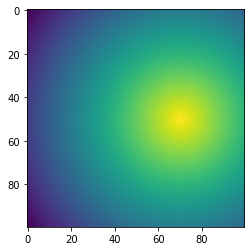

In [5]:
plt.imshow(dist)

In [52]:
grad = gradLayer(dist.unsqueeze(0).unsqueeze(0))

In [53]:
grad = grad.squeeze()

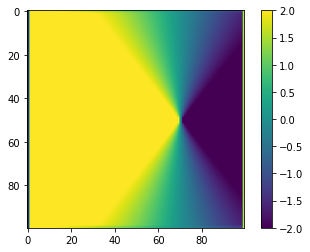

In [54]:
plt.imshow((grad.clamp(-2, 2))[0]); plt.colorbar()

In [58]:
# t = 1e-3
# plt.figure(figsize=(20,5))
# plt.subplot(1,7,1)
# plt.imshow(gc[0][:-2] > t); plt.axis('off')
# plt.subplot(1,7,2)
# plt.imshow(gc[0][2:] < t); plt.axis('off')
# plt.subplot(1,7,3)

# plt.imshow(torch.logical_and(gc[0][2:] < t, gc[0][:-2] > -t)); plt.axis('off')
# plt.subplot(1,7,4)
# plt.imshow(gc[1][:,:-2] > t); plt.axis('off')
# plt.subplot(1,7,5)
# plt.imshow(gc[1][:,2:] < t); plt.axis('off')
# plt.subplot(1,7,6)
# plt.imshow(torch.logical_and(gc[1][:,2:] < t, gc[1][:,:-2] > -t)); plt.axis('off')
# plt.subplot(1,7,7)
# plt.imshow(torch.logical_and(
#     torch.logical_and(gc[1][:,2:] < t, gc[1][:,:-2] > -t)[1:-1,:],
#     torch.logical_and(gc[0][2:] < t, gc[0][:-2] > -t)[:,1:-1],
# )); plt.axis('off')

In [56]:
torch.where(torch.logical_and(torch.logical_and(gc[1][:,2:] < t, gc[1][:,:-2] > -t)[1:-1,:],
    torch.logical_and(gc[0][2:] < t, gc[0][:-2] > -t)[:,1:-1]))

NameError: name 'gc' is not defined

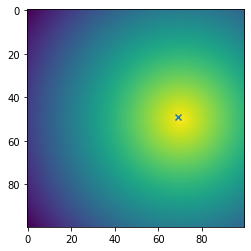

In [57]:
plt.imshow(dist)
plt.scatter(69, 49, marker='x');

In [6]:
# now try it for a more complicated distribution
import torch.distributions as td

In [7]:
loc1 = torch.Tensor([5, 7])
cov1 = torch.Tensor([[1.,0],
                     [0,0.1]])
d1 = td.MultivariateNormal(loc1, cov1)

loc2 = torch.Tensor([3, 5])
cov2 = torch.Tensor([[0.1,0],
                     [0,1.]])
d2 = td.MultivariateNormal(loc2, cov2)

loc3 = torch.Tensor([5, 5])
cov3 = torch.Tensor([[0.7,0.5],
                     [0.5,1.]])
d3 = td.MultivariateNormal(loc3, cov3)

inp = grid.swapaxes(0,-1)

d3 = td.MultivariateNormal(loc3, cov3)
inp = grid.swapaxes(0,-1)

prob = d1.log_prob(inp).exp() + d2.log_prob(inp).exp() + d3.log_prob(inp).exp()

prob.requires_grad_(True)

tensor([[8.5231e-10, 1.4691e-09, 2.4765e-09,  ..., 8.5345e-32, 1.7040e-32,
         3.3276e-33],
        [1.0562e-09, 1.8408e-09, 3.1378e-09,  ..., 3.1073e-31, 6.2734e-32,
         1.2388e-32],
        [1.2886e-09, 2.2709e-09, 3.9143e-09,  ..., 1.1139e-30, 2.2740e-31,
         4.5404e-32],
        ...,
        [2.7763e-22, 4.5947e-22, 8.1510e-22,  ..., 8.1951e-09, 4.8076e-09,
         2.7584e-09],
        [1.7877e-23, 3.1825e-23, 9.4500e-23,  ..., 6.5986e-09, 3.9143e-09,
         2.2710e-09],
        [1.1139e-24, 3.3656e-24, 3.1825e-23,  ..., 5.2312e-09, 3.1378e-09,
         1.8408e-09]], requires_grad=True)

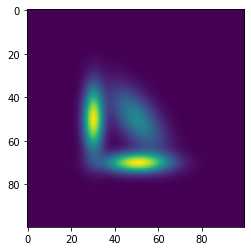

In [8]:
plt.imshow(prob.detach());

In [9]:
prob.shape

torch.Size([100, 100])

In [10]:
out = torch.nn.functional.max_pool2d(prob.unsqueeze(0).unsqueeze(0), kernel_size=5, stride=1, padding=2)

In [118]:
out.squeeze()[wheres[0], wheres[1]]

tensor([0.5061, 0.2373, 0.5139], grad_fn=<IndexBackward0>)

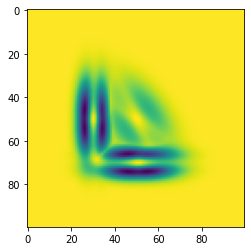

In [123]:
plt.imshow(prob == out.squeeze())

In [64]:
from torchmetrics.functional import image_gradients

In [65]:
dy, dx = image_gradients(prob.unsqueeze(0).unsqueeze(0))
dy = dy.squeeze()
dx = dx.squeeze()

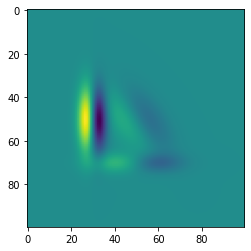

In [66]:
plt.imshow(dx.squeeze())

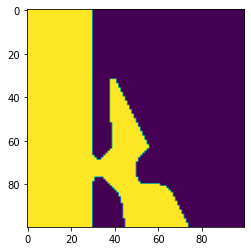

In [67]:
t = 0
plt.imshow(dx > 0)

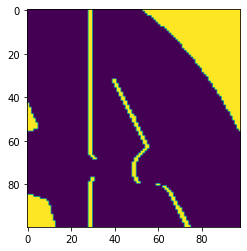

In [68]:
t=1e-10
xdif = torch.logical_and(dx[:,:-2] > -t, dx[:,2:] < t)
ydif = torch.logical_and(dy[:-2] > -t, dy[2:] < t)
plt.imshow(xdif)

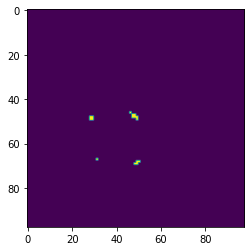

In [69]:
outs = torch.logical_and(torch.logical_and(xdif[1:-1], ydif[:,1:-1]), prob[1:-1,1:-1] > 0.01)
plt.imshow(outs);

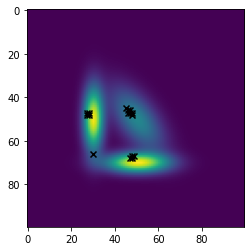

In [70]:
plt.imshow(prob)
wheres = torch.where(outs)
plt.scatter(wheres[1]-1, wheres[0]-1, marker='x', c='black')

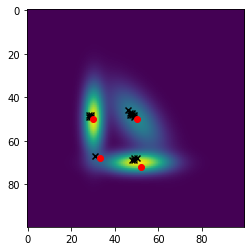

In [71]:
# now do the greedy matching bit
exs = torch.Tensor([50, 50, 68, 72])
eys = torch.Tensor([30, 50, 33, 52])
plt.imshow(prob)
wheres = torch.where(outs)
plt.scatter(wheres[1], wheres[0], marker='x', c='black')
plt.scatter(eys, exs, marker='o', c='r')

In [72]:
points_pred = torch.stack(wheres, dim=1)
points_true = torch.stack([exs, eys], dim=1)

In [73]:
dists = []
for pt in points_true:
    dists.append(((points_pred[:,0] - pt[0]).square() + (points_pred[:,1] - pt[1]).square()).sqrt())

In [74]:
dists[0]

tensor([16.4924, 17.2627, 18.2483,  2.8284,  2.2361, 17.1172, 18.1108, 19.1050,
         2.2361,  1.4142, 19.0263, 17.0294, 26.1725, 26.9072, 26.1725, 26.8701])

In [75]:
distances = torch.zeros(points_true.shape[0])
matches = torch.zeros(points_true.shape[0])

In [76]:
os = torch.stack([outs.unsqueeze(0), outs.unsqueeze(0), outs.unsqueeze(0)], dim=0)

In [77]:
ws = torch.where(os)

In [78]:
ws

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([46, 47, 47, 48, 48, 48, 48, 48, 49, 49, 49, 67, 68, 68, 69, 69, 46, 47,
         47, 48, 48, 48, 48, 48, 49, 49, 49, 67, 68, 68, 69, 69, 46, 47, 47, 48,
         48, 48, 48, 48, 49, 49, 49, 67, 68, 68, 69, 69]),
 tensor([46, 47, 48, 28, 29, 47, 48, 49, 28, 29, 49, 31, 49, 50, 48, 49, 46, 47,
         48, 28, 29, 47, 48, 49, 28, 29, 49, 31, 49, 50, 48, 49, 46, 47, 48, 28,
         29, 47, 48, 49, 28, 29, 49, 31, 49, 50, 48, 49]))

In [478]:
torch.where(ws[0] == 0)[0]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [445]:
dists, indices = torch.stack(dists, dim=1).min(dim=1)

In [451]:
total_points = points_true.shape[0]

In [452]:
# this should be zero, and if there is a point missing it should be less than zero.
total_points - torch.unique(indices).shape[0]

0

In [543]:
torch.Tensor([]).shape[0]

0

### combining the loss together, nice

In [665]:
# calculate where the medians of the lesions are

# calculate the global maximas of the images in a batch this time
def global_maximas(imgs):
    print(imgs.grad_fn)
    dy, dx = image_gradients(imgs)
    print(dy.grad_fn)
    
    # dy = dy.squeeze()
    # dx = dx.squeeze()
    t=1e-10
    print((dx[:,:,:,:-2] > -t).grad_fn)
    # look for changes in direction of the gradient
    x_maxima = torch.logical_and(dx[:,:,:,:-2] > -t, dx[:,:,:,2:] < t)
    print(x_maxima.grad_fn)
    y_maxima = torch.logical_and(dy[:,:,:-2] > -t, dy[:,:,2:] < t)
    # get maxima in both x and y, excluding points where the output is less then 0.01.
    maxima = torch.logical_and(torch.logical_and(x_maxima[:,:,1:-1], y_maxima[:,:,:,1:-1]), imgs[:,:,1:-1,1:-1] > 0.01)
    print(maxima.grad_fn)
    
    maxima = torch.where(maxima)
    print(maxima[0].grad_fn)
    
    return maxima


def matching(maximas, points):
    batch_size = points.shape[0]
    dists_loss = torch.Tensor([0.]).to(points.device)
    missing_points = []
    extra_points = []
    for i, pts in enumerate(points):
        
        # deal with the fixed size batch problem
        points_true = pts[torch.where(pts[:,0] != -1)]
        
        # get the locations of the maximas for this image
        maximas_i_locs = torch.where(maximas[0] == i)[0]
        xs = maximas[2][maximas_i_locs]
        ys = maximas[3][maximas_i_locs]
        pred_points = torch.stack([xs, ys], dim=1)
        
        # keep track of how many extra points there were predicted
        # we want to keep this to a minimum
        extra_points.append(pred_points.shape[0] - points_true.shape[0])
        
        # if there are no points
        if points_true.shape[0] == 0:
            missing_points.append(0)
            batch_size -= 1
            continue
        
        # compute distance between each point
        dists = []
        for pt in points_true:
            dists.append(((pred_points[:,0] - pt[0]).square() + (pred_points[:,1] - pt[1]).square()).sqrt())
        
        # find the true point with the minimum distance
        dists, indices = torch.stack(dists, dim=1).min(dim=1)
        dists_loss += dists.mean()
        
        missing_points.append(points_true.shape[0] - torch.unique(indices).shape[0])
        
    return dists_loss/batch_size, torch.Tensor(missing_points), torch.Tensor(extra_points)
        
    
def matching_loss(imgs, points):
    maximas = global_maximas(imgs)
    print(points.device, maximas[0].device)
    mean_dists, missing_points, extra_points = matching(maximas, points)
    
    loss = mean_dists + torch.mean(missing_points) + torch.mean(extra_points) * 0.01
    return loss

In [619]:
imgs = torch.stack([prob.unsqueeze(0), prob.unsqueeze(0),prob.unsqueeze(0)])

In [620]:
pt = torch.cat([points_true, torch.Tensor([[-1,-1]])])

In [621]:
ps = torch.stack([pt, pt, pt])

In [622]:
maximas = global_maximas(imgs)

In [623]:
matching(maximas, ps)

(tensor([3.3284]), tensor([0., 0., 0.]), tensor([12., 12., 12.]))

In [624]:
matching_loss(imgs, ps)

tensor([4.5284])

In [629]:
preds = model(xs.cuda())

In [666]:
imgs = preds
pt = ys
maximas = global_maximas(preds)

None
None
None
None


In [671]:
torch.logical_and(preds*2, preds/2).grad_fn

In [648]:
maximas

(tensor([ 0,  0,  0,  ..., 63, 63, 63], device='cuda:0'),
 tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0'),
 tensor([  0,   1,   1,  ..., 221, 221, 221], device='cuda:0'),
 tensor([ 56,   1,   9,  ...,  86,  87, 142], device='cuda:0'))

In [645]:
matching_loss(preds, ys.cuda())


cuda:0 cuda:0


tensor([88.5496], device='cuda:0')

### standard

In [646]:
optimizer_params={"lr":2e-4, "momentum":0.6}
optimizer = torch.optim.RMSprop
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [649]:
model = StandardLitModelWrapper(model, matching_loss, 
                                logging_metric=lambda : None,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

In [650]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [651]:
x1, y1 = next(iter(val_dataloader))

In [652]:
x1.device, model.device

(device(type='cpu'), device(type='cpu'))

In [653]:
with torch.no_grad():
    model = model.cuda()
    result = model(x1.cuda())


### train

In [655]:
trainer.fit(model, train_dataloader, val_dataloader)

Missing logger folder: lightning_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | HyperMapp3r | 2.8 M 
--------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.098    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

cuda:0 cuda:0
cuda:0 cuda:0


/home/benp/anaconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

cuda:0 cuda:0


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [75]:
trainer.validate(model, val_dataloader)#, ckpt_path='best')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            134.87911987304688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 134.87911987304688}]

In [74]:
help(trainer.logger)

Help on TensorBoardLogger in module pytorch_lightning.loggers.tensorboard object:

class TensorBoardLogger(pytorch_lightning.loggers.base.LightningLoggerBase)
 |  TensorBoardLogger(save_dir: str, name: Optional[str] = 'lightning_logs', version: Union[int, str, NoneType] = None, log_graph: bool = False, default_hp_metric: bool = True, prefix: str = '', sub_dir: Optional[str] = None, agg_key_funcs: Optional[Mapping[str, Callable[[Sequence[float]], float]]] = None, agg_default_func: Optional[Callable[[Sequence[float]], float]] = None, **kwargs)
 |  
 |  Log to local file system in `TensorBoard <https://www.tensorflow.org/tensorboard>`_ format.
 |  
 |  Implemented using :class:`~torch.utils.tensorboard.SummaryWriter`. Logs are saved to
 |  ``os.path.join(save_dir, name, version)``. This is the default logger in Lightning, it comes
 |  preinstalled.
 |  
 |  Example:
 |  
 |  .. testcode::
 |  
 |      from pytorch_lightning import Trainer
 |      from pytorch_lightning.loggers import Tens

In [104]:
count = 0
for i in x1:
    if torch.sum(i[1]) == 0:
        count += 1

In [105]:
print(count)

14


In [106]:
a = torch.randn(2, 3, 224, 160)

In [107]:
model(x1)

TypeError: 'dict' object is not callable

In [ ]:
trainer.validate(model, val_dataloader)

In [53]:
x1, y1 = next(iter(val_dataloader))

In [56]:
with torch.no_grad():
    model.eval()
    y_hat = model(x1[0:32].to(model.device))

In [43]:
torch.max(x1)

tensor(12.9938)

In [66]:
#dice_loss(y_hat, y1)
ssn_diceloss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(0.9903, device='cuda:0')

In [43]:
TverskyLoss(beta=0.7)(y_hat, y1)

tensor(0.1480)

In [59]:
def actual_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)
    # count how many times the ground truth and target have nothing in them
    s0 = y_hat.shape[0]
    y_hat = y_hat.view(s0, -1)
    y_true = y_true.view(s0, -1)
    print(torch.sum(torch.sum(y_true, dim=1) == 0))
    print(torch.sum(torch.sum(y_hat, dim=1) == 0))
    print(torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0)))
    ignores = torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0))
    
    
    numerator = torch.sum(2 * y_true * y_hat, dim=1)
    print(numerator)
    denominator = torch.sum(y_true + y_hat, dim=1)
    print(denominator)
    
    return torch.sum((numerator)/ (denominator + 1e-8)) / (s0-ignores) # s0

In [60]:
def slice_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [61]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [50]:
dice(y_hat, y1)

tensor(0.8270)

In [51]:
actual_dice(y_hat, y1)

tensor(41)
tensor(40)
tensor(40)
tensor([  62,    0, 1426,  322,    0,    0,    0,    0,  104,    0,   36,   84,
           0,   22,  246,    0,    0,    0,    0, 1092,    0,    0,    0,    0,
           0,   32,    0, 1594,    0,  308,  132,    0,    0,    0,    0,    0,
        2100,    0,  134,  186,    0,    0,    0, 1740,    0, 1234,    0,   10,
           0,    0,  124,   52,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  154,    0])
tensor([  75,    0, 1600,  435,    0,    0,    0,    3,  163,    0,   59,  118,
           0,   29,  331,    0,    0,    1,    0, 1259,    0,    0,    0,    0,
           0,   51,    0, 1943,    0,  370,  230,    0,    0,    0,    0,    0,
        2349,    0,  218,  299,    0,    0,    0, 2106,    0, 1458,    0,   18,
           0,    0,  135,   92,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  194,    0])


tensor(0.6783)

In [50]:
ssn_diceloss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(0.2354)

In [51]:
mc_loss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(48.9333)

RuntimeError: The size of tensor a (2) must match the size of tensor b (224) at non-singleton dimension 0

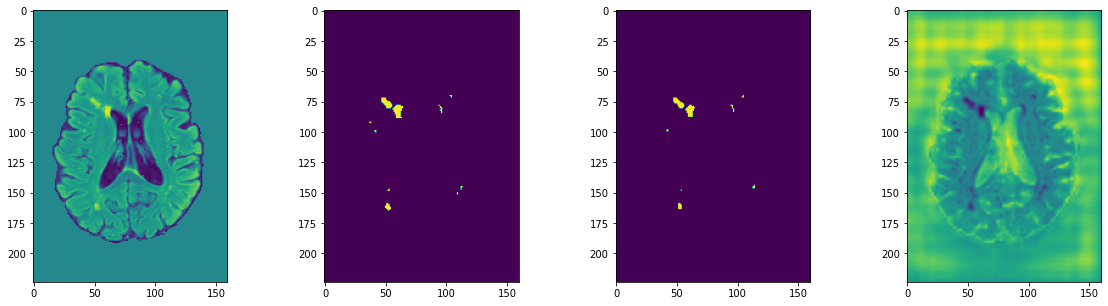

In [69]:
ind = 25
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:])
plt.subplot(1,4,2)
plt.imshow(y1[ind])
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)[ind])
plt.subplot(1,4,4)
plt.imshow(y_hat['logit_mean'].cpu()[ind][0])
print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

In [64]:
y_hat['logit_mean'].cpu()[ind].shape

torch.Size([2, 224, 160])

In [56]:
values = []
for ind in range(len(y1)):
    value = slice_dice(y_hat[ind].unsqueeze(0), y1[ind])
    print(value)
    if value != "n/a" and value != 0:
        values.append(value)
print(values)
print(torch.mean(torch.Tensor(values)))

tensor(0.8267)
n/a
tensor(0.8913)
tensor(0.7402)
n/a
n/a
n/a
tensor(0.)
tensor(0.6380)
n/a
tensor(0.6102)
tensor(0.7119)
n/a
tensor(0.7586)
tensor(0.7432)
n/a
n/a
tensor(0.)
n/a
tensor(0.8674)
n/a
n/a
n/a
n/a
n/a
tensor(0.6275)
n/a
tensor(0.8204)
n/a
tensor(0.8324)
tensor(0.5739)
n/a
n/a
n/a
n/a
n/a
tensor(0.8940)
n/a
tensor(0.6147)
tensor(0.6221)
n/a
n/a
n/a
tensor(0.8262)
n/a
tensor(0.8464)
n/a
tensor(0.5556)
n/a
n/a
tensor(0.9185)
tensor(0.5652)
n/a
n/a
n/a
n/a
n/a
n/a
n/a
n/a
n/a
n/a
tensor(0.7938)
n/a
[tensor(0.8267), tensor(0.8913), tensor(0.7402), tensor(0.6380), tensor(0.6102), tensor(0.7119), tensor(0.7586), tensor(0.7432), tensor(0.8674), tensor(0.6275), tensor(0.8204), tensor(0.8324), tensor(0.5739), tensor(0.8940), tensor(0.6147), tensor(0.6221), tensor(0.8262), tensor(0.8464), tensor(0.5556), tensor(0.9185), tensor(0.5652), tensor(0.7938)]
tensor(0.7399)


### Looking at the 3D dice

In [58]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
# BIG NOTE
# during evaluating the modle, we set is_3d false here to avoid doing the z cropping (which can cause nans)
# and instead we run the whole brain scan through and it gives us a good prediction over all. Nice.
datasets_domains_3d = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]


# split into train, val test datasets
datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains_3d]

# concat the train val test datsets
train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

In [60]:
len(train_dataset_3d), len(val_dataset_3d), len(test_dataset_3d)

(42, 12, 6)

In [63]:
values = []
with torch.no_grad():
    model.eval()
    for i, (scan, label) in enumerate(train_dataset_3d):
        flipped = scan.permute(1,0,2,3)
        model.eval()
        pred = model(flipped).cpu()
        score = dice(pred, label)
        if not torch.isnan(score):
            values.append(score)
        print(i, score)
mean = torch.mean(torch.Tensor(values))
print("----\nmean: ", mean)

0 tensor(0.8370)
1 tensor(0.5767)
2 tensor(0.8479)
3 tensor(0.7870)
4 tensor(0.8018)
5 tensor(0.8328)
6 tensor(0.8274)
7 tensor(0.8786)
8 tensor(0.8925)
9 tensor(0.8094)
10 tensor(0.8518)
11 tensor(0.6680)
12 tensor(0.8179)
13 tensor(0.5450)
14 tensor(0.7976)
15 tensor(0.3599)
16 tensor(0.4000)
17 tensor(0.8392)
18 tensor(0.3378)
19 tensor(0.8163)
20 tensor(0.6559)
21 tensor(0.7911)
22 tensor(0.7954)
23 tensor(0.5940)
24 tensor(0.8595)
25 tensor(0.4836)
26 tensor(0.8498)
27 tensor(0.5335)
28 tensor(0.5566)
29 tensor(0.7357)
30 tensor(0.5857)
31 tensor(0.7322)
32 tensor(0.7005)
33 tensor(0.6278)
34 tensor(0.6419)
35 tensor(0.6592)
36 tensor(0.8172)
37 tensor(0.6856)
38 tensor(0.7505)
39 tensor(0.8109)
40 tensor(0.6606)
41 tensor(0.7986)
----
mean:  tensor(0.7107)


In [7]:
import torch.nn as nn
from torchinfo import summary

In [4]:
a = nn.Linear(20, 40)
m = torch.nn.utils.spectral_norm(a)

In [5]:
m

Linear(in_features=20, out_features=40, bias=True)

In [8]:
summary(m)

Layer (type:depth-idx)                   Param #
Linear                                   840
Total params: 840
Trainable params: 840
Non-trainable params: 0

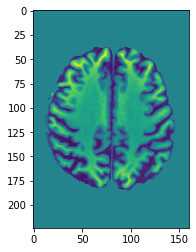

In [68]:
plt.imshow(x1[0][2])

In [143]:
t = RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.))

In [154]:
result = t(x1, x1)

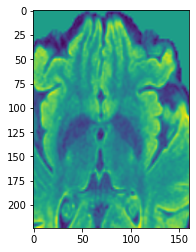

In [155]:
plt.imshow(result[0][33][0])

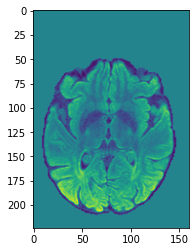

In [116]:
plt.imshow(x1[33][0])

In [139]:
### how many slices in dataset are empty

In [140]:
count = 0
for x, y, in train_dataset:
    if torch.sum(x[1]) == 0:
        count += 1

In [141]:
count

566

In [142]:
len(train_dataset)

2506

In [26]:
x1, y1 = next(iter(train_dataloader))

In [27]:
with torch.no_grad():
    for x, y in train_dataloader:
        model.train()
        result = model(x)

KeyboardInterrupt: 

In [29]:
loss(result, y1.cuda())

tensor(26425.8262, device='cuda:0')

In [30]:
x1.shape

torch.Size([64, 3, 224, 160])

In [ ]:
logits = result_dict['logit_mean']
        distribution = result_dict['distribution']
        
        batch_size = logits.shape[0]
        num_classes = logits.shape[1]
        assert num_classes >= 2  # not implemented for binary case with implied background
        # logit_sample = distribution.rsample((self.num_mc_samples,))
        logit_sample = self.fixed_re_parametrization_trick(distribution, self.num_mc_samples)
        target = target.unsqueeze(1)
        target = target.expand((self.num_mc_samples,) + target.shape)

        flat_size = self.num_mc_samples * batch_size
        logit_sample = logit_sample.view((flat_size, num_classes, -1))
        target = target.reshape((flat_size, -1))

        log_prob = -F.cross_entropy(logit_sample, target, reduction='none').view((self.num_mc_samples, batch_size, -1))
        loglikelihood = torch.mean(torch.logsumexp(torch.sum(log_prob, dim=-1), dim=0) - math.log(self.num_mc_samples))
        loss = -loglikelihood

In [28]:
x1, y1 = next(iter(train_dataloader))
result_dict = model(x1.to(model.device))

In [29]:
def fixed_re_parametrization_trick(dist, num_samples):
    assert num_samples % 2 == 0
    samples = dist.rsample((num_samples // 2,))
    mean = dist.mean.unsqueeze(0)
    samples = samples - mean
    return torch.cat([samples, -samples]) + mean

In [30]:
logits = result_dict['logit_mean']
distribution = result_dict['distribution']

In [58]:
num_mc_samples = 20
target = y1
batch_size = logits.shape[0]
num_classes = logits.shape[1]
assert num_classes >= 2  # not implemented for binary case with implied background
# logit_sample = distribution.rsample((self.num_mc_samples,))
logit_sample = fixed_re_parametrization_trick(distribution, num_mc_samples)

In [59]:
target = target.unsqueeze(1)
target = target.expand((num_mc_samples,) + target.shape)

In [60]:
target.shape

torch.Size([20, 64, 1, 224, 160])

In [61]:
y1.shape

torch.Size([64, 224, 160])

In [62]:
(num_mc_samples,) + y1.shape

(20, 64, 224, 160)

In [63]:
flat_size = num_mc_samples * batch_size
logit_sample = logit_sample.view((flat_size, num_classes, -1))
target = target.reshape((flat_size, -1))

In [64]:
logit_sample.shape, target.shape

(torch.Size([1280, 2, 35840]), torch.Size([1280, 35840]))

In [65]:
log_prob = -F.cross_entropy(logit_sample, target, reduction='none').view((num_mc_samples, batch_size, -1))
loglikelihood = torch.mean(torch.logsumexp(torch.sum(log_prob, dim=-1), dim=0) - math.log(num_mc_samples))
loss = -loglikelihood

In [66]:
loss

tensor(755.0067, grad_fn=<NegBackward0>)

In [115]:
x1[0][1].shape

torch.Size([224, 160])

In [ ]:
"""
so we need to use rms prop, small batch size and a large enough number of mc samples, and care with the learning rate, and it can get down to about 70 nice.
"""